## Libraries

In [1]:
import datetime as dt
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torchdata
import seaborn as sns

from pathlib import Path
from typing import Optional

from catalyst.core import Callback, CallbackOrder, IRunner
from catalyst.dl import SupervisedRunner
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

import zipfile
warnings.simplefilter("ignore")

In [2]:
with zipfile.ZipFile("nfl-player-contact-detection.zip") as z:
    with z.open("train_labels.csv") as f1:
        df_labels = pd.read_csv(f1)
    with z.open("train_baseline_helmets.csv") as f2:
        df_base_helmet = pd.read_csv(f2)
    with z.open("train_player_tracking.csv") as f3:
        df_player_track = pd.read_csv(f3)
    with z.open("train_video_metadata.csv") as f4:
        df_video_metadata = pd.read_csv(f4)

In [3]:
#transi = pd.DataFrame(X.groupby(['game_key', 'play_id'])['nfl_player_id'].nunique()==20)
#transi[transi.nfl_player_id==True]
#X = X[X['game_key'] != 58538]

In [4]:
#df_player_track = df_player_track[df_player_track['game_key'] != 58538]
df_player_track.reset_index(inplace=True)
df_player_track

,index,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,0,58580_001136,58580,1136,44830,2021-10-10T21:08:20.900Z,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64
1,1,58580_001136,58580,1136,47800,2021-10-10T21:08:20.900Z,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90
2,2,58580_001136,58580,1136,52444,2021-10-10T21:08:20.900Z,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33
3,3,58580_001136,58580,1136,46206,2021-10-10T21:08:20.900Z,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62
4,4,58580_001136,58580,1136,52663,2021-10-10T21:08:20.900Z,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353048,1353048,58575_003081,58575,3081,48476,2021-10-10T19:22:06.800Z,140,away,CB,40,72.28,51.80,1.59,0.17,345.36,342.68,0.49,-0.41
1353049,1353049,58575_003081,58575,3081,44887,2021-10-10T19:22:06.800Z,140,away,ILB,45,74.76,54.50,0.98,0.10,342.39,354.46,0.63,-0.24
1353050,1353050,58575_003081,58575,3081,44174,2021-10-10T19:22:06.800Z,140,away,ILB,49,74.54,55.75,1.12,0.11,352.79,349.20,0.63,0.46
1353051,1353051,58575_003081,58575,3081,45217,2021-10-10T19:22:06.800Z,140,away,TE,82,80.44,48.77,1.93,0.20,340.78,346.51,0.53,-0.51


In [5]:
df = df_player_track[['game_play', 'game_key', "play_id", 'nfl_player_id', 'step', 'team', 'x_position', 'y_position', 
                      'datetime', "distance", "speed", "acceleration", "direction", "jersey_number",
                      "orientation", "direction"
                     ]]

df_colision1 = df_labels[['nfl_player_id_1', 'step', 'contact', 'game_play']].rename(columns={'nfl_player_id_1': 'nfl_player_id'}).drop_duplicates()
df_colision2 = df_labels[['nfl_player_id_2', 'step', 'contact', 'game_play']].rename(columns={'nfl_player_id_2': 'nfl_player_id'}).drop_duplicates()
df_colision2 = df_colision2[df_colision2['nfl_player_id'] != 'G']
df_colision2['nfl_player_id'] = df_colision2['nfl_player_id'].astype(int)
df_colision = pd.merge(df_colision1, df_colision2)

df_final = pd.merge(df, df_colision, on=['nfl_player_id', 'step', 'game_play'])
df_final.reset_index(inplace=True)
df_final

,index,game_play,game_key,play_id,nfl_player_id,step,team,x_position,y_position,datetime,distance,speed,acceleration,direction,jersey_number,orientation,direction,contact
0,0,58580_001136,58580,1136,41242,0,home,57.43,25.01,2021-10-10T21:08:31.700Z,0.07,0.63,1.05,28.14,70,59.10,28.14,0
1,1,58580_001136,58580,1136,43330,0,away,59.63,32.99,2021-10-10T21:08:31.700Z,0.01,0.17,0.46,169.43,55,252.78,169.43,0
2,2,58580_001136,58580,1136,52444,0,away,74.72,30.17,2021-10-10T21:08:31.700Z,0.28,2.86,0.71,134.28,29,244.65,134.28,0
3,3,58580_001136,58580,1136,52938,0,home,57.20,23.70,2021-10-10T21:08:31.700Z,0.09,0.77,1.24,11.77,78,81.47,11.77,0
4,4,58580_001136,58580,1136,43351,0,away,65.18,10.65,2021-10-10T21:08:31.700Z,0.04,0.39,0.62,69.38,24,327.26,69.38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399735,399735,58575_003081,58575,3081,46915,72,home,102.76,44.41,2021-10-10T19:22:00.000Z,0.74,7.28,2.38,109.39,86,118.97,109.39,0
399736,399736,58575_003081,58575,3081,44174,72,away,75.61,45.82,2021-10-10T19:22:00.000Z,0.19,1.84,0.37,349.74,49,8.48,349.74,0
399737,399737,58575_003081,58575,3081,46192,72,away,101.22,40.88,2021-10-10T19:22:00.000Z,0.04,0.40,0.54,273.22,81,267.53,273.22,0
399738,399738,58575_003081,58575,3081,44887,72,away,79.44,46.89,2021-10-10T19:22:00.000Z,0.14,1.36,0.48,316.09,45,337.63,316.09,0


In [6]:
def prepare_relative_distances(df: pd.DataFrame):
    distances = []
    orientation_difference = []
    x = df["x_position"].values
    y = df["y_position"].values
    o = df["orientation"].values
    for i in range(len(df)):
        other_row_indices = np.argwhere(np.arange(len(df)) != i).reshape(-1)
        x_others = x[other_row_indices]
        y_others = y[other_row_indices]
        o_others = o[other_row_indices]
        distance_between_players = np.sqrt((x_others - x[i]) ** 2 + (y_others - y[i]) ** 2)
        distances.append(distance_between_players)
        
        abs_orientation_diff = np.abs(o_others - o[i])
        orientation_difference.append(abs_orientation_diff)
    distances_matrix = np.stack(distances)
    orientation_diff_matrix = np.stack(orientation_difference)
    relative_distance_df = pd.concat([
        df[["index"]].reset_index(drop=True),
        pd.DataFrame(distances_matrix, columns=[f"dist{i}" for i in range(distances_matrix.shape[1])]),
        pd.DataFrame(orientation_diff_matrix, columns=[f"od{i}" for i in range(orientation_diff_matrix.shape[1])])
    ], axis=1)
    return relative_distance_df

In [7]:
relative_distances = []
for (game_key, play_id, time), df in tqdm(df_final.groupby(["game_key", "play_id", "datetime"])):
    relative_distances.append(prepare_relative_distances(df))
    
relative_distances_df = pd.concat(relative_distances, axis=0).reset_index(drop=True)

  0%|          | 0/18668 [00:00<?, ?it/s]

In [8]:
relative_distances_df.head()

,index,dist0,dist1,dist2,dist3,dist4,dist5,dist6,dist7,dist8,...,dist22,od22,dist23,od23,dist24,od24,dist25,od25,dist26,od26
0,312339,7.760316,4.007306,3.387890,1.378006,4.315843,3.731340,6.262308,9.773843,2.073475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,312340,7.760316,7.789865,10.842809,7.276318,4.285650,4.033584,13.740713,8.512256,9.001978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,312341,4.007306,7.789865,6.806622,5.140623,6.422087,4.631307,9.270965,6.117393,6.025280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,312342,3.387890,10.842809,6.806622,3.570280,6.854933,6.919747,2.916248,12.875970,1.895178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,312343,1.378006,7.276318,5.140623,3.570280,3.361488,3.427098,6.464921,10.555401,1.739540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_final = df_final.merge(relative_distances_df, on="index", how="left")
df_final

,index,game_play,game_key,play_id,nfl_player_id,step,team,x_position,y_position,datetime,...,dist22,od22,dist23,od23,dist24,od24,dist25,od25,dist26,od26
0,0,58580_001136,58580,1136,41242,0,home,57.43,25.01,2021-10-10T21:08:31.700Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,58580_001136,58580,1136,43330,0,away,59.63,32.99,2021-10-10T21:08:31.700Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,58580_001136,58580,1136,52444,0,away,74.72,30.17,2021-10-10T21:08:31.700Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,58580_001136,58580,1136,52938,0,home,57.20,23.70,2021-10-10T21:08:31.700Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,58580_001136,58580,1136,43351,0,away,65.18,10.65,2021-10-10T21:08:31.700Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399735,399735,58575_003081,58575,3081,46915,72,home,102.76,44.41,2021-10-10T19:22:00.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399736,399736,58575_003081,58575,3081,44174,72,away,75.61,45.82,2021-10-10T19:22:00.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399737,399737,58575_003081,58575,3081,46192,72,away,101.22,40.88,2021-10-10T19:22:00.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399738,399738,58575_003081,58575,3081,44887,72,away,79.44,46.89,2021-10-10T19:22:00.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def prepare_relative_speed_and_acceleration(df: pd.DataFrame):
    distance_columns = [f"dist{i}" for i in range(21)]
    od_columns = [f"od{i}" for i in range(21)]
    diff_df = df[distance_columns].diff().fillna(0).reset_index(drop=True)
    diff_df.columns = [f"speed{i}" for i in range(21)]
    
    acceleration_df = diff_df.diff().fillna(0).reset_index(drop=True)
    acceleration_df.columns = [f"acc{i}" for i in range(21)]
    
    od_diff_df = df[od_columns].diff().fillna(0).reset_index(drop=True)
    od_diff_df.columns = [f"od_diff{i}" for i in range(21)]
    
    relative_speed_and_acceleration = pd.concat([
        df[["index"]].reset_index(drop=True),
        diff_df,
        acceleration_df,
        od_diff_df
    ], axis=1)
    return relative_speed_and_acceleration

In [11]:
relative_speeds = []
for (game_key, play_id, player), df in tqdm(df_final.groupby(["game_key", "play_id", "nfl_player_id"])):
    relative_speeds.append(prepare_relative_speed_and_acceleration(df))
    
relative_speed_df = pd.concat(relative_speeds, axis=0).reset_index(drop=True)

  0%|          | 0/5039 [00:00<?, ?it/s]

In [12]:
df_final = df_final.merge(relative_speed_df, on="index", how="left")
df_final

,index,game_play,game_key,play_id,nfl_player_id,step,team,x_position,y_position,datetime,...,od_diff11,od_diff12,od_diff13,od_diff14,od_diff15,od_diff16,od_diff17,od_diff18,od_diff19,od_diff20
0,0,58580_001136,58580,1136,41242,0,home,57.43,25.01,2021-10-10T21:08:31.700Z,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,1,58580_001136,58580,1136,43330,0,away,59.63,32.99,2021-10-10T21:08:31.700Z,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2,2,58580_001136,58580,1136,52444,0,away,74.72,30.17,2021-10-10T21:08:31.700Z,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
3,3,58580_001136,58580,1136,52938,0,home,57.20,23.70,2021-10-10T21:08:31.700Z,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
4,4,58580_001136,58580,1136,43351,0,away,65.18,10.65,2021-10-10T21:08:31.700Z,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399735,399735,58575_003081,58575,3081,46915,72,home,102.76,44.41,2021-10-10T19:22:00.000Z,...,182.59,-198.36,16.70,184.27,-172.00,-127.33,-84.06,164.72,7.70,0.0
399736,399736,58575_003081,58575,3081,44174,72,away,75.61,45.82,2021-10-10T19:22:00.000Z,...,274.31,-247.34,-21.40,234.59,-253.08,-242.52,-88.76,267.90,-12.40,0.0
399737,399737,58575_003081,58575,3081,46192,72,away,101.22,40.88,2021-10-10T19:22:00.000Z,...,-117.91,102.14,13.32,-116.23,128.50,62.68,178.37,-135.78,4.32,0.0
399738,399738,58575_003081,58575,3081,44887,72,away,79.44,46.89,2021-10-10T19:22:00.000Z,...,-56.42,-27.91,14.86,-241.13,246.54,201.34,317.03,-204.34,5.86,0.0


In [13]:
distance_columns = [f"dist{i}" for i in range(21)]
speed_columns = [f"speed{i}" for i in range(21)]
acceleration_columns = [f"acc{i}" for i in range(21)]
od_columns = [f"od{i}" for i in range(21)]
od_diff_columns = [f"od_diff{i}" for i in range(21)]
df_final[distance_columns]

,dist0,dist1,dist2,dist3,dist4,dist5,dist6,dist7,dist8,dist9,...,dist11,dist12,dist13,dist14,dist15,dist16,dist17,dist18,dist19,dist20
0,8.277705,18.043550,1.330038,16.317846,1.714060,18.185381,17.882662,1.323707,4.794132,14.436856,...,4.669015,3.111302,2.701148,5.996541,2.106466,6.459141,2.959797,7.273101,6.089869,NaN
1,8.277705,15.351238,9.602552,23.019081,6.568044,10.027587,10.354922,7.085266,3.690488,22.629185,...,12.170805,5.307448,6.076924,3.179701,8.421164,10.769406,10.182377,10.408650,6.861669,NaN
2,18.043550,15.351238,18.676491,21.726528,17.100424,19.518084,22.184817,17.898964,15.174960,26.956567,...,17.871077,17.321735,15.719634,17.589594,16.226919,23.900803,16.987222,11.922856,11.970372,NaN
3,1.330038,9.602552,18.676491,15.296500,3.034633,19.514828,19.181705,2.620305,6.080863,13.112109,...,3.679470,4.431569,3.866264,7.300171,2.449694,6.648496,2.382478,7.411518,6.852919,NaN
4,16.317846,23.019081,21.726528,15.296500,17.523028,32.768814,33.360919,17.566801,19.475487,9.030022,...,11.653540,19.075547,17.286367,21.877006,15.038035,21.105241,13.459513,13.212301,16.574782,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399735,8.660052,44.342887,22.807968,19.146812,27.282471,24.487960,29.186781,20.402100,15.710544,6.220804,...,30.740153,4.300256,26.411126,6.698306,35.202415,27.186589,3.851298,23.451499,25.282209,NaN
399736,21.298228,27.704949,5.091562,8.895448,22.464964,11.518507,3.139682,33.788141,21.263739,28.298046,...,12.592077,23.459275,29.895220,21.202464,38.767546,27.186589,26.082095,3.976657,3.134278,NaN
399737,5.629654,41.162086,22.151896,17.530525,23.718560,21.899427,28.389584,16.831572,12.108431,3.150508,...,28.163638,2.940153,22.561624,4.889540,31.376528,3.851298,26.082095,22.593993,24.558375,NaN
399738,18.126723,30.231937,1.330038,6.355502,22.432093,11.706964,5.795602,31.719169,19.186005,24.983723,...,14.586549,19.874129,29.014321,17.705866,38.289931,23.451499,3.976657,22.593993,2.084346,NaN


In [14]:
df_final["relative_distance"] = df_final[distance_columns].min(axis=1)
min_value_indices = df_final[distance_columns].idxmin(axis=1).map(
    lambda x: distance_columns.index(x)).reset_index()

speed_values = df_final[speed_columns].values
acceleration_values = df_final[acceleration_columns].values
od_values = df_final[od_columns].values
od_diff_values = df_final[od_diff_columns].values

df_final["relative_speed"] = min_value_indices.apply(lambda row: speed_values[row["index"], row[0]], axis=1)
df_final["relative_acceleration"] = min_value_indices.apply(lambda row: acceleration_values[row["index"], row[0]], axis=1)
df_final["relative_orientation_difference"] = min_value_indices.apply(lambda row: od_values[row["index"], row[0]], axis=1)
df_final["relative_orientation_difference_diff"] = min_value_indices.apply(lambda row: od_diff_values[row["index"], row[0]], axis=1)

In [15]:
df_final = df_final.merge(min_value_indices, left_index=True, right_on="index")

In [16]:
df_final

,index,index_x,game_play,game_key,play_id,nfl_player_id,step,team,x_position,y_position,...,od_diff18,od_diff19,od_diff20,relative_distance,relative_speed,relative_acceleration,relative_orientation_difference,relative_orientation_difference_diff,index_y,0
0,0,0,58580_001136,58580,1136,41242,0,home,57.43,25.01,...,0.00,0.00,0.0,1.323707,0.000000,0.000000,3.74,0.00,0,7
1,1,1,58580_001136,58580,1136,43330,0,away,59.63,32.99,...,0.00,0.00,0.0,3.179701,0.000000,0.000000,174.60,0.00,1,14
2,2,2,58580_001136,58580,1136,52444,0,away,74.72,30.17,...,0.00,0.00,0.0,11.922856,0.000000,0.000000,22.53,0.00,2,18
3,3,3,58580_001136,58580,1136,52938,0,home,57.20,23.70,...,0.00,0.00,0.0,1.330038,0.000000,0.000000,22.37,0.00,3,0
4,4,4,58580_001136,58580,1136,43351,0,away,65.18,10.65,...,0.00,0.00,0.0,9.030022,0.000000,0.000000,216.33,0.00,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399735,399735,399735,58575_003081,58575,3081,46915,72,home,102.76,44.41,...,164.72,7.70,0.0,3.851298,-14.577293,-5.990843,148.56,-84.06,399735,17
399736,399736,399736,58575_003081,58575,3081,44174,72,away,75.61,45.82,...,267.90,-12.40,0.0,3.134278,-17.379622,-18.157674,74.22,-12.40,399736,19
399737,399737,399737,58575_003081,58575,3081,46192,72,away,101.22,40.88,...,-135.78,4.32,0.0,2.940153,-19.579194,-13.816369,170.70,102.14,399737,12
399738,399738,399738,58575_003081,58575,3081,44887,72,away,79.44,46.89,...,-204.34,5.86,0.0,1.330038,-21.312270,-13.478494,4.97,-215.53,399738,2


In [17]:
df_final

,index,index_x,game_play,game_key,play_id,nfl_player_id,step,team,x_position,y_position,...,od_diff18,od_diff19,od_diff20,relative_distance,relative_speed,relative_acceleration,relative_orientation_difference,relative_orientation_difference_diff,index_y,0
0,0,0,58580_001136,58580,1136,41242,0,home,57.43,25.01,...,0.00,0.00,0.0,1.323707,0.000000,0.000000,3.74,0.00,0,7
1,1,1,58580_001136,58580,1136,43330,0,away,59.63,32.99,...,0.00,0.00,0.0,3.179701,0.000000,0.000000,174.60,0.00,1,14
2,2,2,58580_001136,58580,1136,52444,0,away,74.72,30.17,...,0.00,0.00,0.0,11.922856,0.000000,0.000000,22.53,0.00,2,18
3,3,3,58580_001136,58580,1136,52938,0,home,57.20,23.70,...,0.00,0.00,0.0,1.330038,0.000000,0.000000,22.37,0.00,3,0
4,4,4,58580_001136,58580,1136,43351,0,away,65.18,10.65,...,0.00,0.00,0.0,9.030022,0.000000,0.000000,216.33,0.00,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399735,399735,399735,58575_003081,58575,3081,46915,72,home,102.76,44.41,...,164.72,7.70,0.0,3.851298,-14.577293,-5.990843,148.56,-84.06,399735,17
399736,399736,399736,58575_003081,58575,3081,44174,72,away,75.61,45.82,...,267.90,-12.40,0.0,3.134278,-17.379622,-18.157674,74.22,-12.40,399736,19
399737,399737,399737,58575_003081,58575,3081,46192,72,away,101.22,40.88,...,-135.78,4.32,0.0,2.940153,-19.579194,-13.816369,170.70,102.14,399737,12
399738,399738,399738,58575_003081,58575,3081,44887,72,away,79.44,46.89,...,-204.34,5.86,0.0,1.330038,-21.312270,-13.478494,4.97,-215.53,399738,2


In [18]:
df_final['datetime_column'] = pd.to_datetime(df_final['datetime'])

df_final['year'] = df_final['datetime_column'].dt.year
df_final['month'] = df_final['datetime_column'].dt.month
df_final['day'] = df_final['datetime_column'].dt.day
df_final['hour'] = df_final['datetime_column'].dt.hour
df_final['minute'] = df_final['datetime_column'].dt.minute
df_final['second'] = df_final['datetime_column'].dt.second
df_final['second_2'] = df_final['step'] * 0.1 + df_final['second']
df_final.loc[df_final['second_2'] > 60, 'minute'] += 1

df_final = df_final.drop(columns=[ "step","second","datetime_column"])

In [19]:
X = df_final[[
    "index", "game_key", "play_id", "nfl_player_id", "year", "month", "day", "hour", "minute", "second_2", "datetime",
    "x_position", "y_position", "speed", "acceleration", "distance", "orientation", "direction",
    "relative_distance", "relative_speed", "relative_acceleration", 
    "relative_orientation_difference", "relative_orientation_difference_diff",
    "contact"
]]

In [20]:
ss = StandardScaler()
columns = ["x_position", "y_position", "speed", "acceleration", "distance", "orientation", "direction", 
           "relative_distance", "relative_speed", "relative_acceleration",
           "relative_orientation_difference", "relative_orientation_difference_diff"]
transformed = ss.fit_transform(X[columns])
X[columns] = transformed

In [21]:
X

,index,game_key,play_id,nfl_player_id,year,month,day,hour,minute,second_2,...,distance,orientation,direction,direction,relative_distance,relative_speed,relative_acceleration,relative_orientation_difference,relative_orientation_difference_diff,contact
0,0,58580,1136,41242,2021,10,10,21,8,31.0,...,-0.917071,-1.196850,-1.485568,-1.485568,-0.514624,1.068461,0.567502,-0.945806,0.126786,0
1,1,58580,1136,43330,2021,10,10,21,8,31.0,...,-1.197048,0.730515,-0.094185,-0.094185,0.094740,1.068461,0.567502,0.993976,0.126786,0
2,2,58580,1136,52444,2021,10,10,21,8,31.0,...,0.062847,0.649611,-0.440332,-0.440332,2.965315,1.068461,0.567502,-0.732482,0.126786,0
3,3,58580,1136,52938,2021,10,10,21,8,31.0,...,-0.823746,-0.974240,-1.646775,-1.646775,-0.512546,1.068461,0.567502,-0.734299,0.126786,0
4,4,58580,1136,43351,2021,10,10,21,8,31.0,...,-1.057060,1.471687,-1.079449,-1.079449,2.015532,1.068461,0.567502,1.467739,0.126786,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399735,399735,58575,3081,46915,2021,10,10,19,22,7.2,...,2.209334,-0.601066,-0.685442,-0.685442,0.315241,-0.449903,0.230723,0.698343,-0.656117,0
399736,399736,58575,3081,44174,2021,10,10,19,22,7.2,...,-0.357118,-1.700584,1.681456,1.681456,0.079827,-0.741792,-0.453242,-0.145643,0.011297,0
399737,399737,58575,3081,46192,2021,10,10,19,22,7.2,...,-1.057060,0.877297,0.927909,0.927909,0.016091,-0.970898,-0.209193,0.949699,1.078078,0
399738,399738,58575,3081,44887,2021,10,10,19,22,7.2,...,-0.590432,1.574882,1.350080,1.350080,-0.512546,-1.151414,-0.190200,-0.931842,-1.880577,0


# Split

In [22]:
X = X.sort_values(['game_key', 'datetime'], ascending=[True, True])
X.reset_index(inplace=True)
X = X.drop(columns=['level_0','index', 'datetime'])

In [23]:
X.game_key.nunique()

149

In [24]:
game_key_train = X['game_key'].unique()[:120]
game_key_test = X['game_key'].unique()[121:]

In [25]:
mask = X['game_key'].isin(game_key_train)

df_train = X[mask]
df_test = X[~mask]

In [26]:
print(df_train.game_key.nunique())
print(df_test.game_key.nunique())

120
29


In [27]:
X_train = df_train[df_train.columns[:-1]]
y_train = df_train[df_train.columns[-1]]

X_test = df_test[df_test.columns[:-1]]
y_test = df_test[df_test.columns[-1]]

In [28]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (334454, 24)
y_train shape: (334454,)
X_test shape: (65286, 24)
y_test shape: (65286,)


In [29]:
print(y_train.value_counts())
print(y_test.value_counts())

0    327139
1      7315
Name: contact, dtype: int64
0    63772
1     1514
Name: contact, dtype: int64


In [30]:
from imblearn.under_sampling import RandomUnderSampler

resamp = RandomUnderSampler(sampling_strategy='majority')
X_train_rus, y_train_rus = resamp.fit_resample(X_train, y_train)

resamp2 = RandomUnderSampler(sampling_strategy='majority')
X_test_rus, y_test_rus = resamp2.fit_resample(X_test, y_test)

In [31]:
print(y_train_rus.value_counts())
print(y_test_rus.value_counts())

0    7315
1    7315
Name: contact, dtype: int64
0    1514
1    1514
Name: contact, dtype: int64


# Model

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.input_shape, X_train.shape, X_test.shape

((None, 24, 1), (334454, 24), (65286, 24))

In [34]:
model.output_shape, y_train.shape, y_test.shape

((None, 1), (334454,), (65286,))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 24, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 24, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 20)                2580      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 463,913
Trainable params: 463,913
Non-trai

In [36]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=0.5), loss='binary_crossentropy', metrics='accuracy')

In [37]:
model.evaluate(X_test, y_test)

2041/2041 [==============================] - 76s 35ms/step - loss: 0.6744 - accuracy: 0.9768


[0.674365222454071, 0.9768097400665283]

In [38]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=3, validation_split=0.1)

Epoch 1/3
4704/4704 [==============================] - 644s 135ms/step - loss: 0.1070 - accuracy: 0.9780 - val_loss: 0.0955 - val_accuracy: 0.9797
Epoch 2/3
4704/4704 [==============================] - 614s 131ms/step - loss: 0.1028 - accuracy: 0.9780 - val_loss: 0.0905 - val_accuracy: 0.9797
Epoch 3/3
4704/4704 [==============================] - 598s 127ms/step - loss: 0.0464 - accuracy: 0.9871 - val_loss: 0.0308 - val_accuracy: 0.9911


In [39]:
model.evaluate(X_test, y_test)

2041/2041 [==============================] - 64s 31ms/step - loss: 0.0300 - accuracy: 0.9911


[0.029997525736689568, 0.9910547733306885]

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

2041/2041 [==============================] - 63s 30ms/step


In [41]:
y_pred = np.where(y_pred < 0.5, 0, 1)

print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63772
           1       0.83      0.77      0.80      1514

    accuracy                           0.99     65286
   macro avg       0.91      0.89      0.90     65286
weighted avg       0.99      0.99      0.99     65286

Confusion Matrix:
[[63529   243]
 [  341  1173]]


In [42]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model_rus = Sequential()

model_rus.add(LSTM(128, return_sequences=True, input_shape=(X_train_rus.shape[1],1)))
model_rus.add(LSTM(128, return_sequences=True))
model_rus.add(LSTM(128, return_sequences=True))
model_rus.add(LSTM(128))
model_rus.add(Dense(20, activation='relu'))
model_rus.add(Dense(1, activation='sigmoid'))

model_rus.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=0.5), loss='binary_crossentropy', metrics='accuracy')
hist_rus = model_rus.fit(X_train_rus, y_train_rus, batch_size=64, epochs=3, validation_split=0.1)

Epoch 1/3
206/206 [==============================] - 36s 133ms/step - loss: 0.6829 - accuracy: 0.5597 - val_loss: 0.8864 - val_accuracy: 0.1504
Epoch 2/3
206/206 [==============================] - 24s 118ms/step - loss: 0.6749 - accuracy: 0.5649 - val_loss: 0.9501 - val_accuracy: 0.1210
Epoch 3/3
206/206 [==============================] - 25s 122ms/step - loss: 0.6713 - accuracy: 0.5660 - val_loss: 0.8245 - val_accuracy: 0.3999


In [43]:
model_rus.evaluate(X_test, y_test)

2041/2041 [==============================] - 67s 33ms/step - loss: 0.5503 - accuracy: 0.6971


[0.5503436923027039, 0.6971479058265686]

In [44]:
model_rus.evaluate(X_test_rus, y_test_rus)

95/95 [==============================] - 3s 32ms/step - loss: 0.7037 - accuracy: 0.5462


[0.7037026286125183, 0.5462351441383362]

In [45]:
y_pred_rus = model_rus.predict(X_test_rus)
y_pred_rus = np.where(y_pred_rus < 0.5, 0, 1)

print(classification_report(y_test_rus, y_pred_rus))
print('Confusion Matrix:')
print(confusion_matrix(y_test_rus, y_pred_rus))

95/95 [==============================] - 5s 33ms/step
              precision    recall  f1-score   support

           0       0.54      0.70      0.61      1514
           1       0.57      0.39      0.46      1514

    accuracy                           0.55      3028
   macro avg       0.55      0.55      0.54      3028
weighted avg       0.55      0.55      0.54      3028

Confusion Matrix:
[[1062  452]
 [ 922  592]]


In [46]:
from tensorflow.keras.layers import Bidirectional

model_bi = Sequential()
forward_layer = LSTM(64, return_sequences=True)
backward_layer = LSTM(64,return_sequences=True, go_backwards=True)

model_bi.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train_rus.shape[1],1)))
model_bi.add(Bidirectional(LSTM(64)))
model_bi.add(Dense(20, activation='relu'))
model_bi.add(Dense(1, activation='sigmoid'))
model_bi.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=0.5), loss='binary_crossentropy', metrics='accuracy')

In [47]:
hist_bi = model_bi.fit(X_train_rus, y_train_rus, batch_size=64, epochs=3, validation_split=0.1)
model_bi.evaluate(X_test, y_test)

Epoch 1/3
206/206 [==============================] - 21s 62ms/step - loss: 0.6800 - accuracy: 0.5573 - val_loss: 0.8557 - val_accuracy: 0.0089
Epoch 2/3
206/206 [==============================] - 11s 53ms/step - loss: 0.6047 - accuracy: 0.6806 - val_loss: 0.6867 - val_accuracy: 0.7307
Epoch 3/3
2041/2041 [==============================] - 27s 13ms/step - loss: 0.3480 - accuracy: 0.8511


[0.34800440073013306, 0.851055383682251]

In [48]:
model_bi.evaluate(X_test_rus, y_test_rus)

95/95 [==============================] - 1s 13ms/step - loss: 0.5048 - accuracy: 0.7718


[0.5047529935836792, 0.7717965841293335]

2041/2041 [==============================] - 27s 12ms/step
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     63772
           1       0.10      0.70      0.18      1514

    accuracy                           0.85     65286
   macro avg       0.55      0.78      0.55     65286
weighted avg       0.97      0.85      0.90     65286

Confusion Matrix:


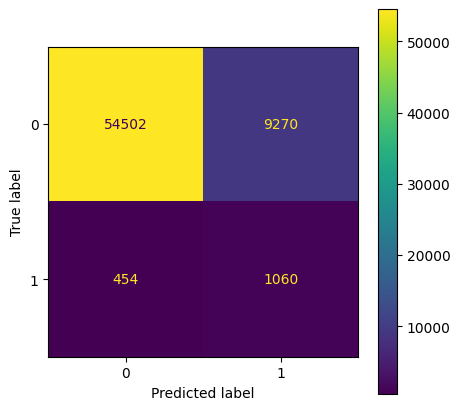

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_bi = model_bi.predict(X_test)
y_pred_bi = np.where(y_pred_bi < 0.5, 0, 1)

print(classification_report(y_test, y_pred_bi))

print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_pred_bi)
f, ax = plt.subplots(figsize=(5,5))
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

In [50]:
y_pred_bi = model_bi.predict(X_test_rus)
y_pred_bi = np.where(y_pred_bi < 0.5, 0, 1)

print(classification_report(y_test_rus, y_pred_bi))
print('Confusion Matrix:')
print(confusion_matrix(y_test_rus, y_pred_bi))

95/95 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      1514
           1       0.82      0.70      0.75      1514

    accuracy                           0.77      3028
   macro avg       0.78      0.77      0.77      3028
weighted avg       0.78      0.77      0.77      3028

Confusion Matrix:
[[1277  237]
 [ 454 1060]]


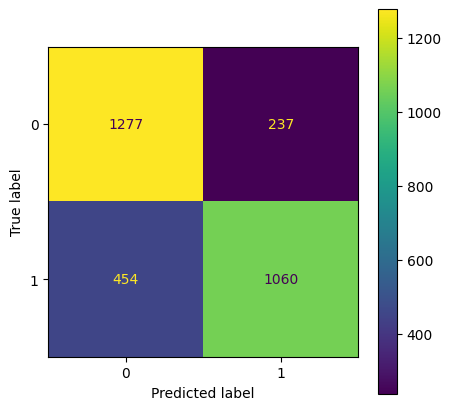

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_rus, y_pred_bi)
f, ax = plt.subplots(figsize=(5,5))
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

# With some filters

In [52]:
df = df_labels[df_labels.nfl_player_id_2 != 'G'].copy()
df.nfl_player_id_2 = df.nfl_player_id_2.astype(int)
merge_cols = ['game_play', 'step', 'nfl_player_id']
add_cols = ['x_position', 'y_position']
for i in range(1,3):
    df = df.merge(df_player_track[merge_cols + add_cols], 
                  left_on=merge_cols[:-1] + [merge_cols[-1] + f'_{i}'], 
                  right_on=merge_cols, how='left').drop('nfl_player_id', axis=1).rename(columns={col: col+f'_{i}' for col in add_cols})
df['distance'] = np.sqrt((df.x_position_1 - df.x_position_2)**2 + (df.y_position_1 - df.y_position_2)**2)
df = df[df.distance < 2.5].copy()

In [53]:
df['datetime_column'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime_column'].dt.year
df['month'] = df['datetime_column'].dt.month
df['day'] = df['datetime_column'].dt.day
df['hour'] = df['datetime_column'].dt.hour
df['minute'] = df['datetime_column'].dt.minute
df['second'] = df['datetime_column'].dt.second
df['second_2'] = df['step'] * 0.1 + df['second']
df.loc[df['second_2'] > 60, 'minute'] += 1

df = df.drop(columns=[ "step","second","datetime_column"])
df

,contact_id,game_play,datetime,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,x_position_2,y_position_2,distance,year,month,day,hour,minute,second_2
4,58168_003392_0_38590_47944,58168_003392,2020-09-11T03:01:48.100Z,38590,47944,0,40.33,25.28,42.10,26.58,2.196110,2020,9,11,3,1,48.0
10,58168_003392_0_38590_44822,58168_003392,2020-09-11T03:01:48.100Z,38590,44822,0,40.33,25.28,39.53,23.63,1.833712,2020,9,11,3,1,48.0
11,58168_003392_0_38590_39947,58168_003392,2020-09-11T03:01:48.100Z,38590,39947,0,40.33,25.28,40.11,26.73,1.466595,2020,9,11,3,1,48.0
13,58168_003392_0_38590_42565,58168_003392,2020-09-11T03:01:48.100Z,38590,42565,0,40.33,25.28,40.75,23.43,1.897077,2020,9,11,3,1,48.0
24,58168_003392_0_43854_46445,58168_003392,2020-09-11T03:01:48.100Z,43854,46445,0,41.99,16.79,40.34,18.08,2.094421,2020,9,11,3,1,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4310823,58582_003121_91_39971_45287,58582_003121,2021-10-12T02:42:29.100Z,39971,45287,0,60.67,42.91,62.90,42.46,2.274951,2021,10,12,2,42,38.1
4310830,58582_003121_91_39971_47872,58582_003121,2021-10-12T02:42:29.100Z,39971,47872,0,60.67,42.91,62.63,42.98,1.961250,2021,10,12,2,42,38.1
4310869,58582_003121_91_43296_46121,58582_003121,2021-10-12T02:42:29.100Z,43296,46121,0,47.87,32.53,49.16,30.92,2.063056,2021,10,12,2,42,38.1
4310891,58582_003121_91_45009_46133,58582_003121,2021-10-12T02:42:29.100Z,45009,46133,0,52.16,34.48,50.42,34.02,1.799778,2021,10,12,2,42,38.1


In [54]:
X = df.sort_values(['game_play', 'datetime'], ascending=[True, True])
X.reset_index(inplace=True)
X = X.drop(columns=['contact_id', 'datetime', 'index'])
X

,game_play,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,x_position_2,y_position_2,distance,year,month,day,hour,minute,second_2
0,58168_003392,38590,47944,0,40.33,25.28,42.10,26.58,2.196110,2020,9,11,3,1,48.0
1,58168_003392,38590,44822,0,40.33,25.28,39.53,23.63,1.833712,2020,9,11,3,1,48.0
2,58168_003392,38590,39947,0,40.33,25.28,40.11,26.73,1.466595,2020,9,11,3,1,48.0
3,58168_003392,38590,42565,0,40.33,25.28,40.75,23.43,1.897077,2020,9,11,3,1,48.0
4,58168_003392,43854,46445,0,41.99,16.79,40.34,18.08,2.094421,2020,9,11,3,1,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354671,58582_003121,39971,45287,0,60.67,42.91,62.90,42.46,2.274951,2021,10,12,2,42,38.1
354672,58582_003121,39971,47872,0,60.67,42.91,62.63,42.98,1.961250,2021,10,12,2,42,38.1
354673,58582_003121,43296,46121,0,47.87,32.53,49.16,30.92,2.063056,2021,10,12,2,42,38.1
354674,58582_003121,45009,46133,0,52.16,34.48,50.42,34.02,1.799778,2021,10,12,2,42,38.1


In [55]:
X.game_play.nunique()

240

In [56]:
game_key_train = X['game_play'].unique()[:192]
game_key_test = X['game_play'].unique()[193:]

In [57]:
mask = X['game_play'].isin(game_key_train)

df_train = X[mask]
df_test = X[~mask]

In [58]:
print(df_train.game_play.nunique())
print(df_test.game_play.nunique())

192
48


In [59]:
X_train = df_train.drop(columns=['contact','game_play'])
y_train = df_train['contact']
X_test = df_test.drop(columns=['contact','game_play'])
y_test = df_test['contact']

In [60]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (283651, 13)
y_train shape: (283651,)
X_test shape: (71025, 13)
y_test shape: (71025,)


In [61]:
print(y_train.value_counts())
print(y_test.value_counts())

0    245419
1     38232
Name: contact, dtype: int64
0    61644
1     9381
Name: contact, dtype: int64


In [62]:
from imblearn.under_sampling import RandomUnderSampler

resamp = RandomUnderSampler(sampling_strategy='majority')
X_train_rus, y_train_rus = resamp.fit_resample(X_train, y_train)

print(y_train_rus.value_counts())

0    38232
1    38232
Name: contact, dtype: int64


In [63]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

model_bi = Sequential()
forward_layer = LSTM(64, return_sequences=True)
backward_layer = LSTM(64,return_sequences=True, go_backwards=True)

model_bi.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train_rus.shape[1],1)))
model_bi.add(Bidirectional(LSTM(64)))
model_bi.add(Dense(20, activation='relu'))
model_bi.add(Dense(1, activation='sigmoid'))

model_bi.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=0.5), loss='binary_crossentropy', metrics='accuracy')

In [64]:
hist_bi = model_bi.fit(X_train_rus, y_train_rus, batch_size=64, epochs=100, validation_split=0.1,
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
model_bi.evaluate(X_test, y_test)

Epoch 1/100
1076/1076 [==============================] - 44s 33ms/step - loss: 0.6823 - accuracy: 0.5554 - val_loss: 0.8266 - val_accuracy: 0.0405
Epoch 2/100
1076/1076 [==============================] - 35s 33ms/step - loss: 0.6726 - accuracy: 0.5791 - val_loss: 0.8549 - val_accuracy: 0.1113
Epoch 3/100
1076/1076 [==============================] - 33s 31ms/step - loss: 0.6504 - accuracy: 0.6274 - val_loss: 0.8526 - val_accuracy: 0.2741
Epoch 4/100
1076/1076 [==============================] - 33s 31ms/step - loss: 0.5596 - accuracy: 0.7156 - val_loss: 0.5569 - val_accuracy: 0.7611
Epoch 5/100
1076/1076 [==============================] - 33s 31ms/step - loss: 0.4400 - accuracy: 0.8031 - val_loss: 0.4164 - val_accuracy: 0.8491
Epoch 6/100
1076/1076 [==============================] - 33s 31ms/step - loss: 0.4021 - accuracy: 0.8197 - val_loss: 0.3611 - val_accuracy: 0.8810
Epoch 7/100
1076/1076 [==============================] - 33s 31ms/step - loss: 0.3882 - accuracy: 0.8263 - val_loss: 0

[0.3928301930427551, 0.7899894118309021]

2220/2220 [==============================] - 20s 8ms/step
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     61644
           1       0.38      0.90      0.53      9381

    accuracy                           0.79     71025
   macro avg       0.68      0.84      0.70     71025
weighted avg       0.90      0.79      0.82     71025

Confusion Matrix:


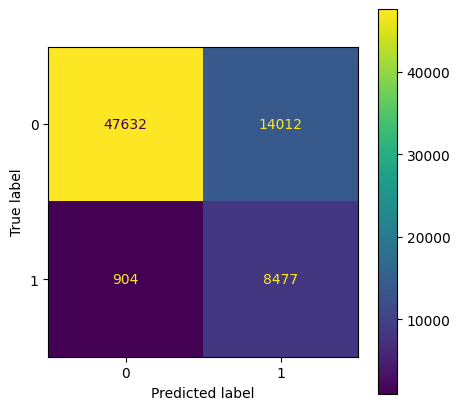

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_bi = model_bi.predict(X_test)
y_pred_bi = np.where(y_pred_bi < 0.5, 0, 1)

print(classification_report(y_test, y_pred_bi))

print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_pred_bi)
f, ax = plt.subplots(figsize=(5,5))
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

In [66]:
from sklearn.metrics import matthews_corrcoef, jaccard_score

mcc_score = matthews_corrcoef(y_test, y_pred_bi)
print("Matthews correlation coefficient:", mcc_score)

jaccard_score = jaccard_score(y_test, y_pred_bi)
print("Jaccard similarity coefficient:", jaccard_score)

Matthews correlation coefficient: 0.4922791667098329
Jaccard similarity coefficient: 0.3623733595520027


In [67]:
y_pred_bi_ravel = y_pred_bi.ravel()
misclassified_mask = (y_test != y_pred_bi_ravel)
misclassified_indices = y_test.index[misclassified_mask]

In [68]:
X_check = X_test[X_test.index.isin(misclassified_indices)]
X_check

,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,x_position_2,y_position_2,distance,year,month,day,hour,minute,second_2
283653,35481,41667,14.25,29.43,14.08,28.56,0.886454,2021,9,19,21,25,19.0
283658,25511,40151,14.16,24.14,13.14,23.92,1.043456,2021,9,19,21,25,19.0
283660,42377,42404,14.03,21.28,13.89,22.45,1.178346,2021,9,19,21,25,19.0
283673,40151,42497,13.14,23.92,12.22,23.44,1.037690,2021,9,19,21,25,19.0
283675,41667,52421,14.08,28.56,13.94,27.35,1.218072,2021,9,19,21,25,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354653,45009,46133,50.80,34.10,49.53,34.01,1.273185,2021,10,12,2,42,36.8
354655,45287,47872,63.09,42.54,62.48,43.43,1.078981,2021,10,12,2,42,36.8
354662,45287,47872,63.02,42.51,62.53,43.30,0.929624,2021,10,12,2,42,36.9
354669,45287,47872,62.95,42.49,62.58,43.13,0.739256,2021,10,12,2,42,38.0


<AxesSubplot: >

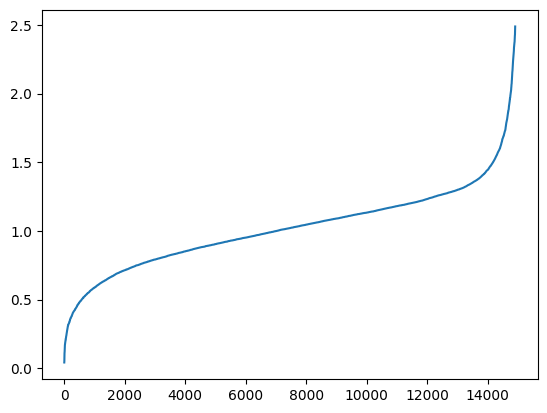

In [69]:
X_check = X_check.sort_values(['distance'], ascending=[True])
X_check.reset_index(inplace=True)
X_check.distance.plot()

# With more features

In [70]:
df = df_labels[df_labels.nfl_player_id_2 != 'G'].copy()

df.nfl_player_id_2 = df.nfl_player_id_2.astype(int)
merge_cols = ['game_play', 'step', 'nfl_player_id']
add_cols = ['x_position', 'y_position', 'speed', 'distance', 'direction', 'orientation', 'acceleration', 'sa']
for i in range(1,3):
    df = df.merge(df_player_track[merge_cols + add_cols], 
                  left_on=merge_cols[:-1] + [merge_cols[-1] + f'_{i}'], 
                  right_on=merge_cols, how='left').drop('nfl_player_id', axis=1).rename(columns={col: col+f'_{i}' for col in add_cols})

    
df['distance'] = np.sqrt((df.x_position_1 - df.x_position_2)**2 + (df.y_position_1 - df.y_position_2)**2)
df = df[df.distance < 1].copy()
df

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,sa_1,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance
1075,58168_003392_4_37084_38567,58168_003392,2020-09-11T03:01:48.500Z,4,37084,38567,1,41.54,20.00,1.07,...,0.40,40.82,19.54,1.72,0.20,125.75,103.92,1.07,1.05,0.854400
1274,58168_003392_5_37211_46445,58168_003392,2020-09-11T03:01:48.600Z,5,37211,46445,0,40.01,16.68,1.68,...,1.57,40.67,17.42,1.63,0.16,155.99,114.56,0.33,0.16,0.991564
1306,58168_003392_5_37084_38567,58168_003392,2020-09-11T03:01:48.600Z,5,37084,38567,1,41.43,19.93,1.21,...,0.39,40.98,19.42,1.92,0.20,126.05,114.49,1.04,1.03,0.680147
1436,58168_003392_6_41944_42565,58168_003392,2020-09-11T03:01:48.700Z,6,41944,42565,1,41.50,22.01,2.12,...,0.76,40.62,22.45,2.03,0.21,187.37,130.56,0.16,0.15,0.983870
1505,58168_003392_6_37211_46445,58168_003392,2020-09-11T03:01:48.700Z,6,37211,46445,0,40.14,16.56,1.82,...,1.23,40.74,17.27,1.63,0.16,155.09,114.56,0.17,-0.15,0.929570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309274,58582_003121_84_45009_46133,58582_003121,2021-10-12T02:42:28.400Z,84,45009,46133,0,48.99,33.55,4.76,...,-2.46,48.23,33.99,3.21,0.34,88.66,82.08,2.06,-2.03,0.878180
4309505,58582_003121_85_45009_46133,58582_003121,2021-10-12T02:42:28.500Z,85,45009,46133,0,49.48,33.70,4.70,...,-1.97,48.57,33.99,3.13,0.34,89.40,85.68,1.82,-1.80,0.955092
4310452,58582_003121_89_45287_47872,58582_003121,2021-10-12T02:42:28.900Z,89,45287,47872,0,63.02,42.51,0.69,...,-0.10,62.53,43.30,1.46,0.14,151.47,121.07,0.73,0.03,0.929624
4310683,58582_003121_90_45287_47872,58582_003121,2021-10-12T02:42:29.000Z,90,45287,47872,0,62.95,42.49,0.67,...,-0.14,62.58,43.13,1.57,0.18,160.04,120.22,1.02,0.28,0.739256


In [71]:
df['datetime_column'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime_column'].dt.year
df['month'] = df['datetime_column'].dt.month
df['day'] = df['datetime_column'].dt.day
df['hour'] = df['datetime_column'].dt.hour
df['minute'] = df['datetime_column'].dt.minute
df['second'] = df['datetime_column'].dt.second
df['second_2'] = df['step'] * 0.1 + df['second']
df.loc[df['second_2'] > 60, 'minute'] += 1

df = df.drop(columns=[ "step","second","datetime_column"])
df

,contact_id,game_play,datetime,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,distance_1,...,orientation_2,acceleration_2,sa_2,distance,year,month,day,hour,minute,second_2
1075,58168_003392_4_37084_38567,58168_003392,2020-09-11T03:01:48.500Z,37084,38567,1,41.54,20.00,1.07,0.11,...,103.92,1.07,1.05,0.854400,2020,9,11,3,1,48.4
1274,58168_003392_5_37211_46445,58168_003392,2020-09-11T03:01:48.600Z,37211,46445,0,40.01,16.68,1.68,0.16,...,114.56,0.33,0.16,0.991564,2020,9,11,3,1,48.5
1306,58168_003392_5_37084_38567,58168_003392,2020-09-11T03:01:48.600Z,37084,38567,1,41.43,19.93,1.21,0.14,...,114.49,1.04,1.03,0.680147,2020,9,11,3,1,48.5
1436,58168_003392_6_41944_42565,58168_003392,2020-09-11T03:01:48.700Z,41944,42565,1,41.50,22.01,2.12,0.21,...,130.56,0.16,0.15,0.983870,2020,9,11,3,1,48.6
1505,58168_003392_6_37211_46445,58168_003392,2020-09-11T03:01:48.700Z,37211,46445,0,40.14,16.56,1.82,0.17,...,114.56,0.17,-0.15,0.929570,2020,9,11,3,1,48.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309274,58582_003121_84_45009_46133,58582_003121,2021-10-12T02:42:28.400Z,45009,46133,0,48.99,33.55,4.76,0.50,...,82.08,2.06,-2.03,0.878180,2021,10,12,2,42,36.4
4309505,58582_003121_85_45009_46133,58582_003121,2021-10-12T02:42:28.500Z,45009,46133,0,49.48,33.70,4.70,0.51,...,85.68,1.82,-1.80,0.955092,2021,10,12,2,42,36.5
4310452,58582_003121_89_45287_47872,58582_003121,2021-10-12T02:42:28.900Z,45287,47872,0,63.02,42.51,0.69,0.08,...,121.07,0.73,0.03,0.929624,2021,10,12,2,42,36.9
4310683,58582_003121_90_45287_47872,58582_003121,2021-10-12T02:42:29.000Z,45287,47872,0,62.95,42.49,0.67,0.07,...,120.22,1.02,0.28,0.739256,2021,10,12,2,42,38.0


In [72]:
X = df.sort_values(['game_play', 'datetime'], ascending=[True, True])
X.reset_index(inplace=True)
X = X.drop(columns=['contact_id', 'datetime', 'index'])
X

,game_play,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,distance_1,direction_1,orientation_1,...,orientation_2,acceleration_2,sa_2,distance,year,month,day,hour,minute,second_2
0,58168_003392,37084,38567,1,41.54,20.00,1.07,0.11,254.82,257.32,...,103.92,1.07,1.05,0.854400,2020,9,11,3,1,48.4
1,58168_003392,37211,46445,0,40.01,16.68,1.68,0.16,133.75,77.82,...,114.56,0.33,0.16,0.991564,2020,9,11,3,1,48.5
2,58168_003392,37084,38567,1,41.43,19.93,1.21,0.14,246.71,257.32,...,114.49,1.04,1.03,0.680147,2020,9,11,3,1,48.5
3,58168_003392,41944,42565,1,41.50,22.01,2.12,0.21,205.03,299.81,...,130.56,0.16,0.15,0.983870,2020,9,11,3,1,48.6
4,58168_003392,37211,46445,0,40.14,16.56,1.82,0.17,134.51,75.82,...,114.56,0.17,-0.15,0.929570,2020,9,11,3,1,48.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65981,58582_003121,45009,46133,0,48.99,33.55,4.76,0.50,71.21,65.07,...,82.08,2.06,-2.03,0.878180,2021,10,12,2,42,36.4
65982,58582_003121,45009,46133,0,49.48,33.70,4.70,0.51,72.23,65.07,...,85.68,1.82,-1.80,0.955092,2021,10,12,2,42,36.5
65983,58582_003121,45287,47872,0,63.02,42.51,0.69,0.08,251.86,256.08,...,121.07,0.73,0.03,0.929624,2021,10,12,2,42,36.9
65984,58582_003121,45287,47872,0,62.95,42.49,0.67,0.07,252.10,255.20,...,120.22,1.02,0.28,0.739256,2021,10,12,2,42,38.0


In [73]:
X.game_play.nunique()

239

In [74]:
game_key_train = X['game_play'].unique()[:192]
game_key_test = X['game_play'].unique()[193:]

In [75]:
mask = X['game_play'].isin(game_key_train)

df_train = X[mask]
df_test = X[~mask]

In [76]:
print(df_train.game_play.nunique())
print(df_test.game_play.nunique())

192
47


In [77]:
X_train = df_train.drop(columns=['contact','game_play'])
y_train = df_train['contact']
X_test = df_test.drop(columns=['contact','game_play'])
y_test = df_test['contact']

In [78]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (52072, 25)
y_train shape: (52072,)
X_test shape: (13914, 25)
y_test shape: (13914,)


In [79]:
print(y_train.value_counts())
print(y_test.value_counts())

1    27479
0    24593
Name: contact, dtype: int64
0    7022
1    6892
Name: contact, dtype: int64


In [80]:
from imblearn.under_sampling import RandomUnderSampler

resamp = RandomUnderSampler(sampling_strategy='majority')
X_train_rus, y_train_rus = resamp.fit_resample(X_train, y_train)

print(y_train_rus.value_counts())

0    24593
1    24593
Name: contact, dtype: int64


In [81]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

model_bi = Sequential()
forward_layer = LSTM(64, return_sequences=True)
backward_layer = LSTM(64,return_sequences=True, go_backwards=True)

model_bi.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train_rus.shape[1],1)))
model_bi.add(Bidirectional(LSTM(64)))
model_bi.add(Dense(20, activation='relu'))
model_bi.add(Dense(1, activation='sigmoid'))

model_bi.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=0.5), loss='binary_crossentropy', metrics='accuracy')

In [82]:
hist_bi = model_bi.fit(X_train_rus, y_train_rus, batch_size=64, epochs=100, validation_split=0.2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
model_bi.evaluate(X_test, y_test)

Epoch 1/100
615/615 [==============================] - 43s 58ms/step - loss: 0.6464 - accuracy: 0.6293 - val_loss: 0.9088 - val_accuracy: 0.3280
Epoch 2/100
615/615 [==============================] - 34s 55ms/step - loss: 0.6223 - accuracy: 0.6442 - val_loss: 0.9549 - val_accuracy: 0.3952
Epoch 3/100
615/615 [==============================] - 34s 55ms/step - loss: 0.6174 - accuracy: 0.6502 - val_loss: 0.8992 - val_accuracy: 0.4552
Epoch 4/100
615/615 [==============================] - 34s 56ms/step - loss: 0.6123 - accuracy: 0.6528 - val_loss: 0.9191 - val_accuracy: 0.4416
Epoch 5/100
615/615 [==============================] - 33s 54ms/step - loss: 0.6087 - accuracy: 0.6560 - val_loss: 0.9465 - val_accuracy: 0.4529
Epoch 6/100
615/615 [==============================] - 36s 59ms/step - loss: 0.6043 - accuracy: 0.6582 - val_loss: 0.8506 - val_accuracy: 0.5217
Epoch 7/100
615/615 [==============================] - 36s 59ms/step - loss: 0.5973 - accuracy: 0.6663 - val_loss: 0.8508 - val_ac

[0.6240630745887756, 0.6666666865348816]

435/435 [==============================] - 6s 12ms/step
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      7022
           1       0.69      0.59      0.64      6892

    accuracy                           0.67     13914
   macro avg       0.67      0.67      0.66     13914
weighted avg       0.67      0.67      0.66     13914

Confusion Matrix:


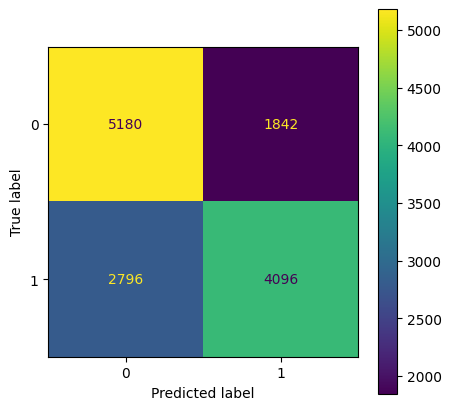

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_bi = model_bi.predict(X_test)
y_pred_bi = np.where(y_pred_bi < 0.5, 0, 1)

print(classification_report(y_test, y_pred_bi))

print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_pred_bi)
f, ax = plt.subplots(figsize=(5,5))
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

In [84]:
from sklearn.metrics import matthews_corrcoef, jaccard_score

mcc_score = matthews_corrcoef(y_test, y_pred_bi)
print("Matthews correlation coefficient:", mcc_score)

jaccard_score = jaccard_score(y_test, y_pred_bi)
print("Jaccard similarity coefficient:", jaccard_score)

Matthews correlation coefficient: 0.33559878117993047
Jaccard similarity coefficient: 0.4689718342111289


In [85]:
y_pred_bi_ravel = y_pred_bi.ravel()
misclassified_mask = (y_test != y_pred_bi_ravel)
misclassified_indices = y_test.index[misclassified_mask]
X_check = X_test[X_test.index.isin(misclassified_indices)]
X_check[['nfl_player_id_1', 'nfl_player_id_2', 'x_position_1', 'y_position_1',
       'speed_1', 'distance_1', 'direction_1', 'orientation_1',
       'acceleration_1', 'sa_1', 'x_position_2', 'y_position_2', 'speed_2',
       'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2',
       'distance']].head()

,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,direction_1,orientation_1,acceleration_1,sa_1,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance
52077,40151,42497,13.07,23.77,0.40,0.03,195.85,275.39,0.37,0.06,12.25,23.47,0.12,0.02,70.86,84.87,0.16,0.08,0.873155
52078,40151,42497,13.08,23.76,0.19,0.02,159.32,270.06,0.61,-0.14,12.29,23.43,0.21,0.05,114.54,83.46,0.34,0.27,0.856154
52079,40151,42497,13.11,23.75,0.23,0.03,111.80,263.58,0.73,0.32,12.31,23.42,0.26,0.03,117.83,81.37,0.34,0.29,0.865390
52080,40151,42497,13.14,23.75,0.33,0.04,92.12,262.69,0.71,0.47,12.35,23.41,0.31,0.04,113.34,76.23,0.35,0.33,0.860058
52081,42480,46163,12.64,26.20,0.95,0.10,67.58,118.15,0.35,-0.34,13.55,25.89,0.34,0.03,6.25,297.56,0.39,0.11,0.961353


In [86]:
y_pred_bi_ravel = y_pred_bi.ravel()
misclassified_mask = (y_test != y_pred_bi_ravel)
goodclassified_indices = y_test.index[~misclassified_mask]
X_check = X_test[(X_test.index.isin(goodclassified_indices)) & (X_test['nfl_player_id_1'] == 40151)]
X_check[['nfl_player_id_1', 'nfl_player_id_2', 'x_position_1', 'y_position_1',
       'speed_1', 'distance_1', 'direction_1', 'orientation_1',
       'acceleration_1', 'sa_1', 'x_position_2', 'y_position_2', 'speed_2',
       'distance_2', 'direction_2', 'orientation_2', 'acceleration_2', 'sa_2',
       'distance']].head()

,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,direction_1,orientation_1,acceleration_1,sa_1,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance
52074,40151,42497,13.12,23.88,0.36,0.04,217.43,302.41,0.51,0.42,12.22,23.45,0.10,0.01,14.12,88.92,0.20,0.18,0.997447
52075,40151,42497,13.10,23.85,0.42,0.04,208.57,291.20,0.88,0.65,12.23,23.47,0.12,0.01,22.59,88.32,0.15,0.13,0.949368
52076,40151,42497,13.08,23.81,0.52,0.05,195.65,285.02,0.86,0.66,12.24,23.48,0.14,0.01,34.55,87.45,0.12,0.09,0.902497
52228,40151,42480,15.12,22.96,1.13,0.11,122.18,158.09,1.20,-1.20,14.77,23.75,2.19,0.22,165.88,134.64,1.04,-0.11,0.864060
52229,40151,46163,15.12,22.96,1.13,0.11,122.18,158.09,1.20,-1.20,15.15,23.87,1.62,0.17,152.69,118.44,1.60,-1.56,0.910494
